# Manila Seismic Risk Beneficiaries

This script...


Load modules and packages:

In [1]:
import pandas as pd
import geopandas as gpd
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from bokeh.plotting import save, figure, show
from bokeh.models import GeoJSONDataSource
from bokeh.tile_providers import CARTODBPOSITRON, get_provider

In [3]:
sys.path.append("C://Users/wb555300/OneDrive - WBG/Documents/GitHub/GOSTnetAddons/")
sys.path.append("C://Users/wb555300/OneDrive - WBG/Documents/GitHub/GOST_PublicGoods/GOSTNets/GOSTNets")
import GOSTnet as gn
import GostnetAddons as gna

Set working directory:

In [4]:
os.chdir('C://Users/wb555300/OneDrive - WBG/Manila_Seismic/')

Decide on crs for project:

In [5]:
proj_crs = {'init': 'epsg:' + str(3123)}
lonlat_crs = {'init': 'epsg:' + str(4326)}

**Read data**
- on hospitals:

In [6]:
#manila hospitals:
mani_hos = gpd.read_file('DATA/For_WB_Schools_Hospitals/MetroManila/MetroManila/DOH/HealthFacilities.shp')
#greater manila hospitals:
gmma_hos = gpd.read_file('DATA/For_WB_Schools_Hospitals/GMMA/DOH/HealthFacilities.shp')

- on schools

In [7]:
#manila schools:
mani_sch = gpd.read_file('DATA/For_WB_Schools_Hospitals/MetroManila/MetroManila/DepEd/SchoolLocation.shp')
#greater manila schools:
gmma_sch = gpd.read_file('DATA/For_WB_Schools_Hospitals/GMMA/DepEd/SchoolLocation.shp')

- on officially selected buildings:

In [8]:
#officially selected buildings:
selec_buil = gpd.read_file('DATA/1287_Eligible_Buildings_Location/1287_Eligible_Buildings_Location.shp')
#Hospitals:
selec_hos = selec_buil[selec_buil['Type_Occup']=='Hospitals and Facilities']
#Schools:
selec_sch = selec_buil[selec_buil['Type_Occup']=='Schools and Facilities']

**Understand to which extent data agrees:**

- data for gmma agrees with man but covers a larger area; i.e. man is a subset of gmma
- selec build might contain multiple buildings at the same location (!) -> filter the unique ones


Identify unique locations:

In [15]:
# unique school locations:
selec_sch_u = selec_sch.drop_duplicates(['geometry'])

# unique hospital locations:
selec_hos_u = selec_hos.drop_duplicates(['geometry'])

Project to metric projection:

In [16]:
selec_sch_u_p = selec_sch_u.to_crs(proj_crs)
selec_hos_u_p = selec_hos_u.to_crs(proj_crs)

mani_sch_p = mani_sch.to_crs(proj_crs)
mani_hos_p = mani_hos.to_crs(proj_crs)

Save data in csv for further processing:

In [17]:
selec_sch.drop(columns ='geometry').to_csv('DATA/Hospitals_Schools_csv/selected_schools.csv')
selec_hos.drop(columns ='geometry').to_csv('DATA/Hospitals_Schools_csv/selected_hospitals.csv')

mani_sch.drop(columns = 'geometry').to_csv('DATA/Hospitals_Schools_csv/all_schools.csv')
mani_hos.drop(columns = 'geometry').to_csv('DATA/Hospitals_Schools_csv/all_hospitals.csv')

**Nearest neighbor mapping**

In [18]:
def prepend(list, str): 
      
    # Using format() 
    str += '{0}'
    list = [str.format(i) for i in list] 
    return(list) 

In [19]:
def nn_index(gdf1,gdf2, k = 1):
    """
    Function that takes a spatial point gdf1 and returns indices and distances
    of k nearest neighbors in spatial point gdf2 
    """
    gd1 = gdf1.copy()
    gd2 = gdf2.copy()
           
    ## NN lookup
    #Import spatial from scipy for very quick NN lookup:
    from scipy import spatial
    
    G_tree = spatial.KDTree(np.array([gd2.geometry.x, gd2.geometry.y]).T)
    distances, indices = G_tree.query(np.array([gd1.geometry.x, gd1.geometry.y]).T, k = k)
    
    indici = gd2.index.values[indices]
    
    col_names = prepend(np.arange(1,k+1,1).astype(str), 'index_k_') + prepend(np.arange(1,k+1,1).astype(str), 'dist_k_')
    
    result = pd.DataFrame(np.column_stack([indici, distances]), columns= col_names, index = gd1.index)
    result[prepend(np.arange(1,k+1,1).astype(str), 'index_k_')]= result[prepend(np.arange(1,k+1,1).astype(str), 'index_k_')].astype(int)
    
    return result

**Distances to nearest neighbors:**

For hospitals:

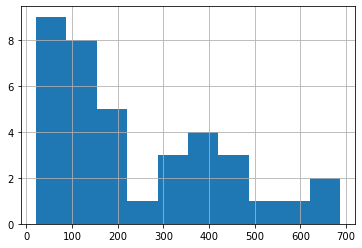

In [20]:
nn_index(selec_hos_u_p,mani_hos_p, k = 1).iloc[:,1].hist()
plt.show()

For schools:

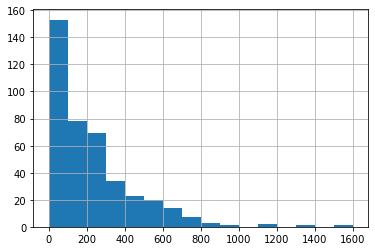

In [21]:
nn_index(selec_sch_u_p,mani_sch_p, k = 1).iloc[:,1].hist(bins = np.arange(0,1700,100))
plt.show()

*The majority of hospitals and schools are further than 100 metres from their nearest neighbors*

Furthermore multiple locations are mapped to the same buildings; taking for example hospitals there are 37 unique hospitals in the data, but they are mapped to only 30 hospitals in the 'full' dataset.

In [23]:
print('Number of hospitals selected for upgrade:', len(selec_hos_u_p))
print('Number of hospitals these are mapped to:', len(gna.unique(nn_index(selec_hos_u_p,mani_hos_p, k = 1)['index_k_1'])))
print('Unique mappings occur 25 times \n duplications occur 4 times and \n a "quadrication" occurs 1 time')

nn_index(selec_hos_u_p,mani_hos_p, k = 1)['index_k_1'].value_counts().value_counts()

Number of hospitals selected for upgrade: 37
Number of hospitals these are mapped to: 30
Unique mappings occur 25 times 
 duplications occur 4 times and 
 a "quadrication" occurs 1 time


1    25
2     4
4     1
Name: index_k_1, dtype: int64

For schools we have the following:

In [24]:
print('Number of schools selected for upgrade:', len(selec_sch_u))
print('Number of schools these are mapped to:', len(gna.unique(nn_index(selec_sch_u_p,mani_sch_p, k = 1)['index_k_1'])))

nn_index(selec_sch_u_p,mani_sch_p, k = 1)['index_k_1'].value_counts().value_counts()

Number of schools selected for upgrade: 406
Number of schools these are mapped to: 296


1    215
2     58
3     19
5      2
4      2
Name: index_k_1, dtype: int64

**Do mapping anyway and see if & when names agree:**

For hospitals:

In [25]:
#Index of nearest neighbors:
NN_hos_index = nn_index(selec_hos_u_p,mani_hos_p, k = 1)['index_k_1']

#Select columns used for merging:
cols = ['facilityn','healthf1', 'ownership', 'ownership1', 'sourcelat', 'precision', 'bedcapacit', 'grassess', 'notes', 'geometry']

#Merge (i.e. add the information form the NN to the selected data frame)
selec_hos_u_p_combn = selec_hos_u_p.reset_index().merge(mani_hos_p.loc[NN_hos_index, cols].reset_index().add_prefix('NN_'), left_index = True, right_index = True)

Compare names:

Do the same for schools:

In [26]:
#Index of nearest neighbors:
NN_sch_index = nn_index(selec_sch_u_p,mani_sch_p, k = 1)['index_k_1']
NN_sch_dist = nn_index(selec_sch_u_p,mani_sch_p, k = 1)['dist_k_1']

#Select columns used for merging:
cols = ['schoolname','enrollment', 'mooeinph', 'offering', 'geometry', 'datasource']

#Merge (i.e. add the information form the NN to the selected data frame)
selec_sch_u_p_combn = selec_sch_u_p.reset_index().merge(mani_sch_p.loc[NN_sch_index, cols].reset_index().add_prefix('NN_'), left_index = True, right_index = True)

#add distance to NN:
selec_sch_u_p_combn['NN_dist'] = NN_sch_dist.reset_index(drop = True)

In [27]:
def extract_school_name(x):
    temp_list = x.upper().split(',')
    temp_iden = list(map(lambda y: 'SCHOOL' in y, temp_list))
    if np.any(temp_iden):
        temp = np.where(temp_iden)[0]
        return np.array(temp_list)[temp][0].strip()
    else:
        return x

In [28]:
selec_sch_u_p_combn['School_N'] = selec_sch_u_p_combn['Building_N'].apply(extract_school_name)

**Alternatively, do mapping based on names**

Write a function that cleans the name:

In [29]:
import string
def clean_name(name, replace_dict = {}, to_upper = True):
    new_name = []
    #remove punctuation:
    name = ''.join([char for char in name if char not in string.punctuation])
    #Go through every word in the old name and adjust it
    for word in name.split():
        word = word.strip()
        if word in replace_dict:
            word = replace_dict[word]
        if to_upper == True:
            word = word.upper()
        new_name.append(word)
    new_name = ' '.join(new_name)
    return new_name

And a function that does NN neighbor matching on strings:

In [136]:
import jellyfish as jf
def string_NN_map(names1, names2, k, dist_fun = jf.jaro_winkler):
    """
    Function that takes a pd.Series of names1 and returns for each element the closest k names in the pd.Series names2
    as measured by teh specified distance function. Default: jaro winkler
    """
    names1_ind = names1.index
    names2_ind = names2.index
    
    #calculate distances:
    dist_mat = np.array([[jf.jaro_winkler(word1, word2) for word2 in list(names2)] for word1 in list(names1)])
    
    #obtain location indicies of k nearest neighbors (taking into account that sort orders increasingly):
    k_NN_iloc = np.flip(dist_mat.argsort(axis = 1)[:,-k:], axis =1)
    
    #obtain actual indicies of k nearest neighbors:
    k_NN_loc = names2_ind.values[k_NN_iloc]
    
    #translate indicies to names:
    k_NN_names = np.apply_along_axis(lambda x: names2.loc[x], 1, k_NN_loc)
    
    #obtain distance to k NN:
    k_NN_dist = np.array([list(dist_mat[x, k_NN_iloc[x,:]]) for x in np.arange(dist_mat.shape[0])])
    
    #Store results in pandas data frame
    #Prepare column names:
    col_names = prepend(np.arange(1,k+1,1).astype(str), 'index_k_') + prepend(np.arange(1,k+1,1).astype(str), 'name_k_') + prepend(np.arange(1,k+1,1).astype(str), 'dist_k_')
    #prepare result:
    result = pd.DataFrame(np.column_stack([k_NN_loc, k_NN_names, k_NN_dist]), columns = col_names, index = names1_ind)
    
    return result

Function to extract school name from name column:

In [30]:
def extract_school_name(x):
    temp_list = x.upper().split(',')
    temp_iden = list(map(lambda y: 'SCHOOL' in y, temp_list))
    if np.any(temp_iden):
        temp = np.where(temp_iden)[0]
        return np.array(temp_list)[temp][0].strip()
    else:
        return x

In [31]:
#pd.Series of names from first data source:
names1 = selec_sch_u_p['Building_N'].apply(extract_school_name).apply(clean_name)

In [32]:
#pd.Series of names from second data source:
names2 = mani_sch_p['schoolname'].apply(clean_name, replace_dict = {'ES': 'elementary school', 
                                                           'HS': 'high school',
                                                           'NHS': 'national high school'})

Do matching based on names for schools:

In [158]:
school_nn_names = string_NN_map(names1, names2, k = 5)

Add matching based on spatial distance:

In [ ]:
school_nn_dist = nn_index(selec_sch_u_p, mani_sch_p, k = 3)

In [154]:
for x in np.arange(3):
    school_nn_dist['name_k_'+str(x+1)] =  np.array(mani_sch_p['schoolname'].loc[school_nn_dist['index_k_'+str(x+1)]])

Combine all results in one data set to be manually merged:

In [162]:
man_merge_school = pd.concat([names1, school_nn_names, school_nn_dist.add_prefix('sp_')], axis = 1)

man_merge_school.to_csv('DATA/Hospitals_Schools_csv/school_man_merge.csv')

In [177]:
#For how many do we have a perfect string match:
print('Perfect sring match for:', round((man_merge_school['dist_k_1']==1).mean(),4))

#For how many do spatial & string matches agree:
print('Spatial & string match for:', round((man_merge_school['index_k_1']==man_merge_school['sp_index_k_1']).mean(), 4))

Perfect sring match for: 0.569
Spatial & string match for: 0.3399


In [179]:
sum(man_merge_school['dist_k_1']!=1)

175

In [181]:
len(selec_hos_u)

37

In [178]:
33.99/56.9

0.5973637961335677

In [33]:
#As lists:
names1_l = list(names1)
names2_l = list(names2)

In [34]:
import string
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

In [142]:
pd.concat([names1, string_NN_map(names1, names2, k = 5)], axis = 1)

,Building_N,index_k_1,index_k_2,index_k_3,index_k_4,index_k_5,name_k_1,name_k_2,name_k_3,name_k_4,name_k_5,dist_k_1,dist_k_2,dist_k_3,dist_k_4,dist_k_5
0,PINYAHAN ELEMENTARY SCHOOL,518,392,199,371,356,PINYAHAN ELEMENTARY SCHOOL,PINAGBUHATAN ELEMENTARY SCHOOL,TUNASAN ELEMENTARY SCHOOL,CANIOGAN ELEMENTARY SCHOOL,NANGKA ELEMENTARY SCHOOL,1,0.914803,0.908718,0.908584,0.905789
2,PINYAHAN ELEMENTARY SCHOOL,518,392,199,371,356,PINYAHAN ELEMENTARY SCHOOL,PINAGBUHATAN ELEMENTARY SCHOOL,TUNASAN ELEMENTARY SCHOOL,CANIOGAN ELEMENTARY SCHOOL,NANGKA ELEMENTARY SCHOOL,1,0.914803,0.908718,0.908584,0.905789
4,SEDP BUILDING 8CL MANUEL ROXAS HIGH SCHOOL,479,442,150,495,10,JUDGE FELICIANO BELMONTE SR HIGH SCHOOL,CAMP GEN E AGUINALDO HIGH SCHOOL,GEN PIO DEL PILAR NATIONAL HIGH SCHOOL,MANUEL A ROXAS HIGH SCHOOL,MANUEL A ROXAS HIGH SCHOOL,0.756077,0.739484,0.732587,0.718926,0.718926
5,MANUEL ROXAS HIGH SCHOOL,495,10,736,92,329,MANUEL A ROXAS HIGH SCHOOL,MANUEL A ROXAS HIGH SCHOOL,MANUEL L QUEZON HIGH SCHOOL,MANUEL L QUEZON HIGH SCHOOL,MANDALUYONG HIGH SCHOOL,0.942949,0.942949,0.904815,0.904815,0.861686
6,MANUEL ROXAS HIGH SCHOOL,495,10,736,92,329,MANUEL A ROXAS HIGH SCHOOL,MANUEL A ROXAS HIGH SCHOOL,MANUEL L QUEZON HIGH SCHOOL,MANUEL L QUEZON HIGH SCHOOL,MANDALUYONG HIGH SCHOOL,0.942949,0.942949,0.904815,0.904815,0.861686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1258,NEW ERA ELEMENTARY SCHOOL,504,372,505,39,612,NEW ERA ELEMENTARY SCHOOL,DE CASTRO ELEMENTARY SCHOOL,NEW ERA HIGH SCHOOL,P GUEVARA ELEMENTARY SCHOOL,SAN ROQUE ELEMENTARY SCHOOL,1,0.867969,0.864561,0.852817,0.851487
1261,ROSA L SUSANO ELEMENTARY SCHOOL QUIRINO HIGHWAY,533,397,40,0,30,ROSA L SUSANO NOVALICHES ELEMENTARY SCHOOL,ROSARIO ELEMENTARY SCHOOL,RAJA SOLIMAN SCIENCE AND TECHNOLOGY HIGH SCHOOL,E DELOS SANTOS ELEMENTARY SCHOOL,MOISES SALVADOR ELEMENTARY SCHOOL,0.874178,0.835794,0.758827,0.740248,0.73141
1265,SERGIO OSMENA SR HIGH SCHOOL,548,97,57,477,7,SERGIO OSMENA SR HIGH SCHOOL,PRES SERGIO OSMENA SR HIGH SCHOOL,JOSE ABAD SANTOS HIGH SCHOOL,JOSE P LAUREL SR HIGH SCHOOL,CARLOS P GARCIA HIGH SCHOOL,1,0.830447,0.796537,0.796537,0.779101
1267,TORO HILLS ELEMENTARY SCHOOL,556,474,42,551,88,TORO HILLS ELEMENTARY SCHOOL,HOLY SPIRIT ELEMENTARY SCHOOL,F AMORSOLO ELEMENTARY SCHOOL,STO CRISTO ELEMENTARY SCHOOL,M AGONCILLO ELEMENTARY SCHOOL,1,0.890426,0.849206,0.848571,0.839354


In [109]:
dist_mat = np.array([[jf.jaro_winkler(word1, word2) for word2 in names2_l] for word1 in names1_l])

In [96]:
k = 3

In [121]:
k_NN_iloc = np.flip(dist_mat.argsort(axis = 1)[:,-k:], axis =1)
k_NN_loc = names2_ind.values[k_NN_iloc]

In [122]:
k_NN_iloc

array([[518, 392, 199],
       [518, 392, 199],
       [479, 442, 150],
       ...,
       [548,  97,  57],
       [556, 474,  42],
       [557, 262, 135]], dtype=int64)

In [124]:
dist_mat[0, k_NN_iloc[0]]

array([1.        , 0.91480342, 0.90871795])

array([[1.        , 0.91480342, 0.90871795],
       [1.        , 0.91480342, 0.90871795],
       [0.75607726, 0.73948413, 0.73258668],
       ...,
       [1.        , 0.83044733, 0.7965368 ],
       [1.        , 0.89042567, 0.84920635],
       [1.        , 0.87071306, 0.86870027]])

In [ ]:

np.apply_along_axis(lambda x: names2.loc[x], 1, k_NN_indices)

In [98]:
k_NN_indices

array([[557, 262, 135],
       [556, 474,  42],
       [548,  97,  57],
       ...,
       [479, 442, 150],
       [518, 392, 199],
       [518, 392, 199]], dtype=int64)

In [93]:
np.flip(dist_mat[:,-3:])

array([[1.        , 0.87071306, 0.86870027],
       [1.        , 0.89042567, 0.84920635],
       [1.        , 0.83044733, 0.7965368 ],
       ...,
       [0.75607726, 0.73948413, 0.73258668],
       [1.        , 0.91480342, 0.90871795],
       [1.        , 0.91480342, 0.90871795]])

In [40]:
names2_ind = names2.index

In [80]:
string_NN_indices = names2_ind.values[dist_mat.argsort()[:,-3:]]

In [81]:
np.apply_along_axis(lambda x: names2.loc[x], 1, string_NN_indices)

array([['TUNASAN ELEMENTARY SCHOOL', 'PINAGBUHATAN ELEMENTARY SCHOOL',
        'PINYAHAN ELEMENTARY SCHOOL'],
       ['TUNASAN ELEMENTARY SCHOOL', 'PINAGBUHATAN ELEMENTARY SCHOOL',
        'PINYAHAN ELEMENTARY SCHOOL'],
       ['GEN PIO DEL PILAR NATIONAL HIGH SCHOOL',
        'CAMP GEN E AGUINALDO HIGH SCHOOL',
        'JUDGE FELICIANO BELMONTE SR HIGH SCHOOL'],
       ...,
       ['JOSE ABAD SANTOS HIGH SCHOOL',
        'PRES SERGIO OSMENA SR HIGH SCHOOL',
        'SERGIO OSMENA SR HIGH SCHOOL'],
       ['F AMORSOLO ELEMENTARY SCHOOL', 'HOLY SPIRIT ELEMENTARY SCHOOL',
        'TORO HILLS ELEMENTARY SCHOOL'],
       ['VERGONVILLE ELEMENTARY SCHOOL',
        'VILLAMOR AIRBASE ELEMENTARY SCHOOL',
        'VILLA VERDE ELEMENTARY SCHOOL']], dtype=object)

In [62]:
names2.loc[string_NN_indices]

ValueError: Cannot index with multidimensional key

In [408]:
(dist_mat.max(axis = 1)>=0.90).mean()

0.7339901477832512

In [403]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(pd.DataFrame(zip(names1_l,np.array(names2_l)[dist_mat.argmax(axis = 1)], dist_mat.max(axis=1))))

,0,1,2
0,PINYAHAN ELEMENTARY SCHOOL,PINYAHAN ELEMENTARY SCHOOL,1.000000
1,PINYAHAN ELEMENTARY SCHOOL,PINYAHAN ELEMENTARY SCHOOL,1.000000
2,SEDP BUILDING 8CL MANUEL ROXAS HIGH SCHOOL,JUDGE FELICIANO BELMONTE SR HIGH SCHOOL,0.756077
3,MANUEL ROXAS HIGH SCHOOL,MANUEL A ROXAS HIGH SCHOOL,0.942949
4,MANUEL ROXAS HIGH SCHOOL,MANUEL A ROXAS HIGH SCHOOL,0.942949
5,MALAYA ELEMENTARY SCHOOL,MALAYA ELEMENTARY SCHOOL,1.000000
6,KRUS NA LIGAS ELEMENTARY SCHOOL,KRUS NA LIGAS HIGH SCHOOL,0.893960
7,TOMAS MORATO ELEMENTARY SCHOOL,TOMAS MORATO ELEMENTARY SCHOOL,1.000000
8,TOMAS MORATO ELEMENTARY SCHOOL,TOMAS MORATO ELEMENTARY SCHOOL,1.000000
9,MH DEL PILAR ELEMENTARY SCHOOL,PIO DEL PILAR ELEMENTARY SCHOOL,0.909805


In [373]:
most_similar_indi = cosine_similarity(CountVectorizer().fit_transform(names1_l + names2_l).toarray())[0:len(names1),len(names1):].argmax(axis = 1)

pd.DataFrame({'Name 1': names1_l , 'Name 2': np.array(names1_l + names2_l)[most_similar_indi]})

,Name 1,Name 2
0,BAGONG LIPUNAN BUILDING 2 6CL PINYAHAN ELEMENT...,GATCHALIAN ELEMENTARY SCHOOL
1,SANLAKAS BUILDING 6CL PINYAHAN ELEMENTARY SCHO...,GATCHALIAN ELEMENTARY SCHOOL
2,SEDP BUILDING 8CL MANUEL ROXAS HIGH SCHOOL SCT...,MATHAY BUILDING 12CL MH DEL PILAR ELEMENTARY S...
3,SB BUILDING 8CL MANUEL ROXAS HIGH SCHOOL SCT C...,MATHAY BUILDING 12CL MH DEL PILAR ELEMENTARY S...
4,PROPERTY BUILDING LIBRARY AND PROPERTY 4CL MAN...,MATHAY BUILDING 12CL MH DEL PILAR ELEMENTARY S...
...,...,...
401,MATHAY BUILDING NEW ERA ELEMENTARY SCHOOL TAND...,R ALMARIO ELEMENTARY SCHOOL
402,DPWH BUILDING ROSA L SUSANO ELEMENTARY SCHOOL ...,PAMPLONA ELEMENTARY SCHOOL CENTRAL
403,CALALAY BUILDING SERGIO OSMENA SR HIGH SCHOOL ...,CEMBO ELEMENTARY SCHOOL
404,ADMIN BUILDING TORO HILLS ELEMENTARY SCHOOL RO...,GEN PIO DEL PILAR NATIONAL HIGH SCHOOL


In [305]:
name = ' Pinagbuhatan Elementary School'

In [319]:
clean_words = ['school', 'elementary', 'es']

In [324]:
replace_dict = {'ES': 'elementary school',
               'HS': 'high school'}
'high school' in replace_dict

False

In [325]:
replace_dict['ES']

'elementary school'

In [295]:
from difflib import get_close_matches 
get_close_matches('Pinagb', x.split(), n = 1, cutoff = 0.2)

['Pinagbuhatan']

In [339]:
clean_name(' Pinagbuhatan Tiñga ES', replace_dict={'ES': 'elementary school'})

'PINAGBUHATAN TIÑGA ELEMENTARY SCHOOL'

In [311]:
def clean_name(name, clean_words):
    clean_name = []
    for x in name.split():
        word = x.strip().lower()
        if word not in clean_words:
            word = clean_name.append(word)
    return ' '.join(clean_name)

# OLD

In [156]:
test_loc = GeoJSONDataSource(geojson = selec_hos_u_p_combn.drop(columns = 'NN_geometry').to_crs(lonlat_crs).to_json())

In [159]:
tile_provider = get_provider(CARTODBPOSITRON)

In [160]:
p = figure(title = 'Test map')
p.circle('x','y', source = test_loc)
p.add_tile(tile_provider)
show(p)

RuntimeError: Models must be owned by only a single document, Selection(id='1358', ...) is already in a doc

*Ensure that spatial data remains*:

In [29]:
nn_index(slec_sch_u_p,mani_sch_p, k = 1)

,index_k_1,dist_k_1
0,518,789.312559
1,518,789.312559
2,518,227.594759
3,518,789.312559
4,471,246.384491
...,...,...
1266,549,362.018230
1267,435,649.100242
1268,435,649.100242
1269,435,649.100242


In [10]:
#Copy data:
gdf1 = mani_hos_p
gdf2 = selec_hos_p

In [58]:
gd1 = gdf1.copy()
gd2 = gdf2.copy()
    
#Add coordi
gd1['X1'] = gd1.geometry.x
gd1['Y1'] = gd1.geometry.y
    
gd2['X2'] = gd2.geometry.x
gd2['Y2'] = gd2.geometry.y
    
    
## NN lookup
#Import spatial from scipy for very quick NN lookup:
from scipy import spatial
G_tree = spatial.KDTree(gd1[['X1','Y1']].values)
distances, indices = G_tree.query(gd2[['X2','Y2']].values, k=2)

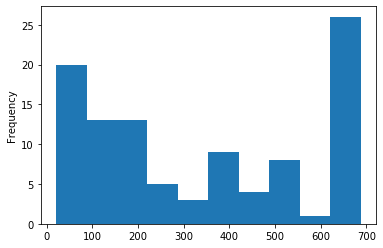

In [40]:
pd.Series(distances[:,0]).plot(kind = 'hist')

In [28]:
# Add coordinates of neigherst neighbor:
mapped_hos = gd2.reset_index(drop = True).merge(gd1.loc[indices[:,0],cols].reset_index(drop = True).rename(columns = {'geometry': 'n_geometry'}),
                                  left_index = True, right_index = True)

In [63]:
indices[:,]

array([[497, 479],
       [633, 683],
       [478, 544],
       [633, 683],
       [633, 683],
       [ 30, 487],
       [ 30, 487],
       [ 30, 487],
       [ 30, 487],
       [530, 513],
       [532, 559],
       [532, 559],
       [542, 513],
       [532, 559],
       [542, 513],
       [312, 308],
       [312, 308],
       [312, 308],
       [312, 308],
       [327, 338],
       [327, 338],
       [327, 338],
       [396, 377],
       [396, 377],
       [396, 377],
       [206, 200],
       [149, 151],
       [691, 715],
       [165, 162],
       [ 12,  13],
       [ 12,  13],
       [ 12,  13],
       [ 12,  13],
       [ 12,  13],
       [ 66,  64],
       [ 66,  64],
       [ 66,  64],
       [ 65,  66],
       [ 65,  66],
       [ 65,  66],
       [ 65,  66],
       [ 12,  13],
       [ 12,  13],
       [ 12,  13],
       [ 12,  10],
       [ 12,  10],
       [ 12,  10],
       [ 12,  10],
       [ 12,  10],
       [ 12,  10],
       [ 12,  10],
       [ 12,  10],
       [ 12,

In [65]:
gd1.index.values[indices]

array([[497, 479],
       [633, 683],
       [478, 544],
       [633, 683],
       [633, 683],
       [ 30, 487],
       [ 30, 487],
       [ 30, 487],
       [ 30, 487],
       [530, 513],
       [532, 559],
       [532, 559],
       [542, 513],
       [532, 559],
       [542, 513],
       [312, 308],
       [312, 308],
       [312, 308],
       [312, 308],
       [327, 338],
       [327, 338],
       [327, 338],
       [396, 377],
       [396, 377],
       [396, 377],
       [206, 200],
       [149, 151],
       [691, 715],
       [165, 162],
       [ 12,  13],
       [ 12,  13],
       [ 12,  13],
       [ 12,  13],
       [ 12,  13],
       [ 66,  64],
       [ 66,  64],
       [ 66,  64],
       [ 65,  66],
       [ 65,  66],
       [ 65,  66],
       [ 65,  66],
       [ 12,  13],
       [ 12,  13],
       [ 12,  13],
       [ 12,  10],
       [ 12,  10],
       [ 12,  10],
       [ 12,  10],
       [ 12,  10],
       [ 12,  10],
       [ 12,  10],
       [ 12,  10],
       [ 12,

In [34]:
mapped_hos

,Object_ID,City_Addre,Building_N,Type_Occup,Lat_Y,Lat_X,Ground_Rup,Ground_Sha,Liquefacti,geometry,...,ownership,ownership1,sourcelat,precision,bedcapacit,grassess,notes,X1,Y1,n_geometry
0,30,Quezon City,"Phase 1 Building, Quirino Memorial Medical Ce...",Hospitals and Facilities,14.639568,121.06686,Safe,VIII,Safe,POINT (507056.092 1619095.994),...,Government,Local Government Unit,WHO (Barangay Centroid),Low,0,Safe,None,506616.123441,1.619624e+06,POINT (506616.123 1619623.891)
1,31,Quezon City,"Phase 2 Building, Quirino Memorial Medical Cen...",Hospitals and Facilities,14.677414,121.01264,Safe,VIII,Safe,POINT (501215.184 1623282.450),...,Government,Local Government Unit,CHD (GPS),High,0,Safe,None,501042.845961,1.623731e+06,POINT (501042.846 1623731.206)
2,32,Quezon City,"Phase 4 Building, Quirino Memorial Medical Cen...",Hospitals and Facilities,14.623623,121.07413,Safe,VIII,Safe,POINT (507839.771 1617332.051),...,Government,Local Government Unit,CHD (GPS),High,0,Safe,None,507701.838362,1.617454e+06,POINT (507701.838 1617454.489)
3,33,Quezon City,"Phase 6 Building (Admin & 2A), Quirino Memoria...",Hospitals and Facilities,14.677414,121.01264,Safe,VIII,Safe,POINT (501215.184 1623282.450),...,Government,Local Government Unit,CHD (GPS),High,0,Safe,None,501042.845961,1.623731e+06,POINT (501042.846 1623731.206)
4,34,Quezon City,"Phase 6 Building (OPD and ER), Quirino Memoria...",Hospitals and Facilities,14.677595,121.01295,Safe,VIII,Safe,POINT (501248.572 1623302.477),...,Government,Local Government Unit,CHD (GPS),High,0,Safe,None,501042.845961,1.623731e+06,POINT (501042.846 1623731.206)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,1283,Quezon City,"OPD Building, PNP General Hospital, P. Tuazon...",Hospitals and Facilities,14.615743,121.04531,Safe,VIII,Safe,POINT (504735.089 1616459.477),...,Government,Local Government Unit,CHD (GPS),High,0,Safe,None,504854.657978,1.616558e+06,POINT (504854.658 1616557.636)
98,1284,Quezon City,"Surgical Building, PNP General Hospital, P. T...",Hospitals and Facilities,14.615743,121.04531,Safe,VIII,Safe,POINT (504735.089 1616459.477),...,Government,Local Government Unit,CHD (GPS),High,0,Safe,None,504854.657978,1.616558e+06,POINT (504854.658 1616557.636)
99,1285,Quezon City,"Ward Building, PNP General Hospital, P. Tuazo...",Hospitals and Facilities,14.615743,121.04531,Safe,VIII,Safe,POINT (504735.089 1616459.477),...,Government,Local Government Unit,CHD (GPS),High,0,Safe,None,504854.657978,1.616558e+06,POINT (504854.658 1616557.636)
100,1286,San Juan,"San Juan Medical Center, N. Domingo St., San J...",Hospitals and Facilities,14.610563,121.03094,Safe,VIII,Safe,POINT (503186.989 1615886.145),...,Government,Local Government Unit,CHD (GPS),High,0,Safe,None,503181.694122,1.616034e+06,POINT (503181.694 1616034.181)


In [33]:
gd2['Building_N']

29      Phase 1  Building, Quirino Memorial Medical Ce...
30      Phase 2 Building, Quirino Memorial Medical Cen...
31      Phase 4 Building, Quirino Memorial Medical Cen...
32      Phase 6 Building (Admin & 2A), Quirino Memoria...
33      Phase 6 Building (OPD and ER), Quirino Memoria...
                              ...                        
1282    OPD Building, PNP General Hospital,  P. Tuazon...
1283    Surgical Building, PNP General Hospital,  P. T...
1284    Ward Building, PNP General Hospital,  P. Tuazo...
1285    San Juan Medical Center, N. Domingo St., San J...
1286    Army General Hospital, Fort A. Bonifacio, Tagu...
Name: Building_N, Length: 102, dtype: object

In [76]:
gd1.iloc[1,:]

objectid                                                   7492
joincount                                                     1
targetfid                                                  8180
facilityc                                    DOH000000000000314
healthfac                                                   314
facilityn                               NODADO GENERAL HOSPITAL
healthf1                                               Hospital
ownership                                               Private
ownership1                                                 None
streetname                                                 None
buildingn                                                  None
zipcode                                                    3013
landlinen                                         +63 449385997
landline1                                                  None
faxnumber                                         +63 448150754
emailaddre                              

In [40]:
len(selec_hos_p)

102

Code for nearest neighbor mapping:

In [53]:
pd.DataFrame(np.array([gd1.geometry.x, gd1.geometry.y]).T, columns= ['X','Y'])

np.column_stack([np.array([gd1.geometry.x, gd1.geometry.y]).T, np.array([gd1.geometry.x, gd1.geometry.y]).T])


array([[ 498114.09438947, 1630659.09421765,  498114.09438947,
        1630659.09421765],
       [ 504967.71840572, 1629993.89614141,  504967.71840572,
        1629993.89614141],
       [ 496825.91428374, 1614475.29508726,  496825.91428374,
        1614475.29508726],
       ...,
       [ 496193.59123715, 1627263.25801086,  496193.59123715,
        1627263.25801086],
       [ 501171.44679089, 1625334.96147453,  501171.44679089,
        1625334.96147453],
       [ 492289.51690536, 1629286.79921567,  492289.51690536,
        1629286.79921567]])

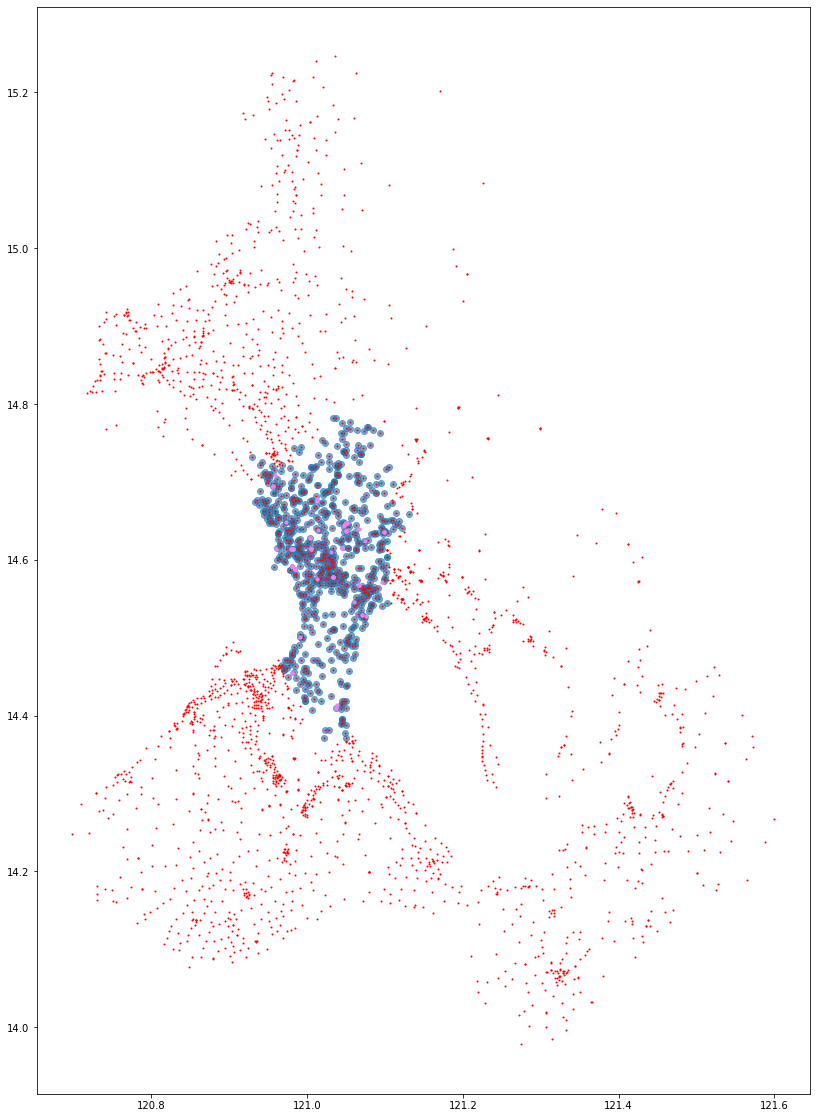

In [21]:
base = mani_hos.plot(figsize = (20,20), alpha = 0.6)
gmma_hos.plot(ax = base, color = 'red', markersize = 1)
selec_buil[selec_buil['Type_Occup']=='Hospitals and Facilities'].plot(ax = base, color = 'violet', markersize = 10)